<a href="https://colab.research.google.com/github/flynt1/torch/blob/master/01_test_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
install.packages(c("tidymodels","torch","torchvision"))

Warning message in install.packages(c("tidymodels", "torch", "torchvision")):
“installation of package ‘torchvision’ had non-zero exit status”
Warning message in install.packages(c("tidymodels", "torch", "torchvision")):
“installation of package ‘recipes’ had non-zero exit status”
Warning message in install.packages(c("tidymodels", "torch", "torchvision")):
“installation of package ‘tune’ had non-zero exit status”
Warning message in install.packages(c("tidymodels", "torch", "torchvision")):
“installation of package ‘tidymodels’ had non-zero exit status”


In [ ]:
library(tidyverse)
library(tidymodels)
library(torch)
library(torchvision)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.0     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



ERROR: ignored

In [ ]:
train= read_csv("/content/cifar10.train.csv", col_types = cols(.default = col_integer()))
test= read_csv("/content/cifar10.test.csv", col_types = cols(.default = col_integer()))

.
   0    1    2    3    4    5    6    7    8    9 
5000 5000 5000 5000 5000 5000 5000 5000 5000 5000 

.
   0    1    2    3    4    5    6    7    8    9 
1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 

Warning message:
“The `x` argument of `as_tibble.matrix()` must have unique column names if `.name_repair` is omitted as of tibble 2.0.0.
Using compatibility `.name_repair`.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


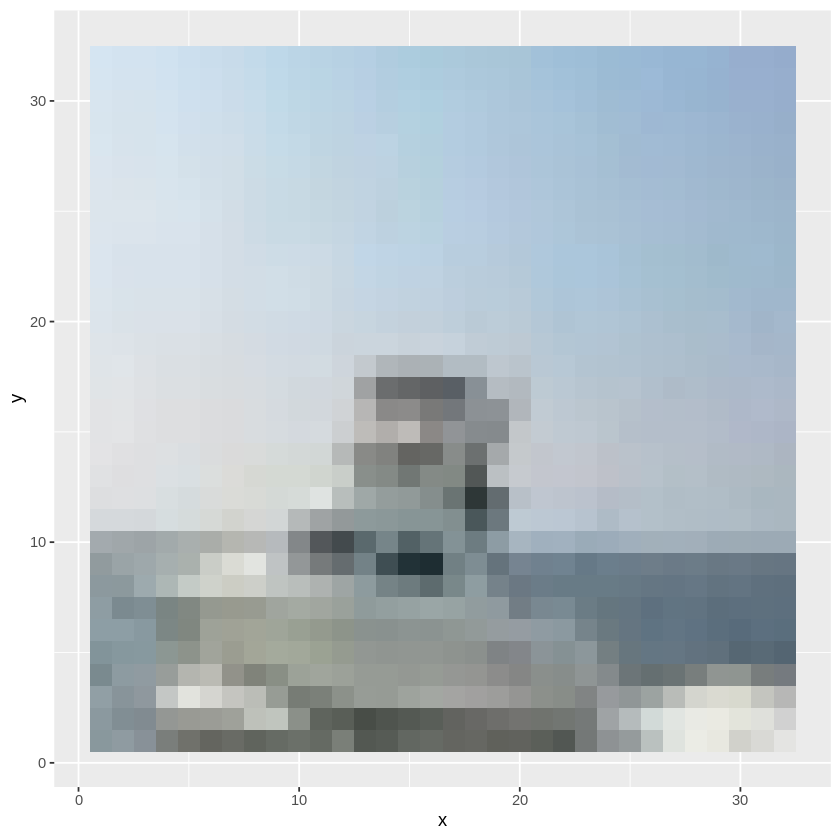

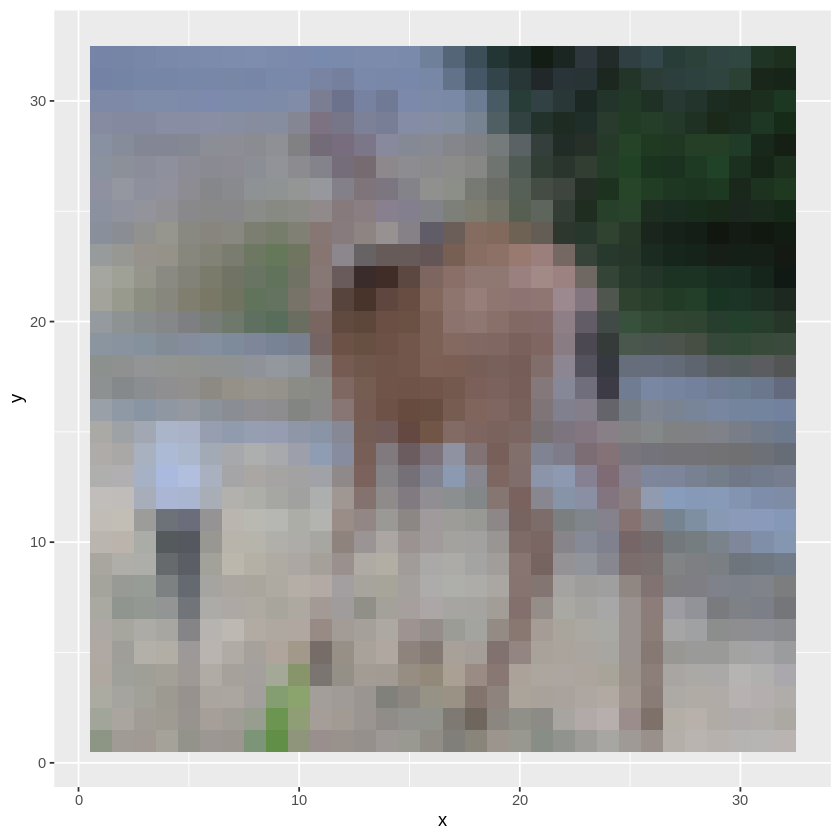

In [ ]:
train$label %>% table()
test$label %>% table()

train[101,1:3072] %>% as_vector() %>% matrix(ncol = 3, byrow = F) %>% as_tibble() %>% 
  set_names(c("r","g","b")) %>% 
  bind_cols(
    expand_grid(
      y=seq(32,1),
      x=seq(1,32))) %>% 
  ggplot(aes(x=x,y=y))+
  geom_tile(aes(fill=rgb(r,g,b, maxColorValue = 255)))+
  scale_fill_identity()+
  coord_fixed(ratio = 1)

test[101,1:3072] %>% as_vector() %>% matrix(ncol = 3, byrow = F) %>% as_tibble() %>% 
  set_names(c("r","g","b")) %>% 
  bind_cols(
    expand_grid(
      y=seq(32,1),
      x=seq(1,32))) %>% 
  ggplot(aes(x=x,y=y))+
  geom_tile(aes(fill=rgb(r,g,b, maxColorValue = 255)))+
  scale_fill_identity()+
  coord_fixed(ratio = 1)

In [ ]:
X.train= train[,1:3072] %>%
  as.matrix() %>% 
  transform_to_tensor() %>% 
  torch_reshape(list(nrow(train),3,32,32))

X.train= X.train$cuda()

X.test= test[,1:3072] %>%
  as.matrix() %>% 
  transform_to_tensor() %>% 
  torch_reshape(list(nrow(test),3,32,32))

X.test= X.test$cuda()

Y.train= train$label %>% as_factor() %>% as.integer() %>% torch_tensor(dtype = torch_int64(), device = "cuda")

Y.test= test$label %>% as_factor() %>% as.integer() %>% torch_tensor(dtype = torch_int64(), device = "cuda")

In [ ]:
X.train$device

torch_device(type='cuda', index=0)

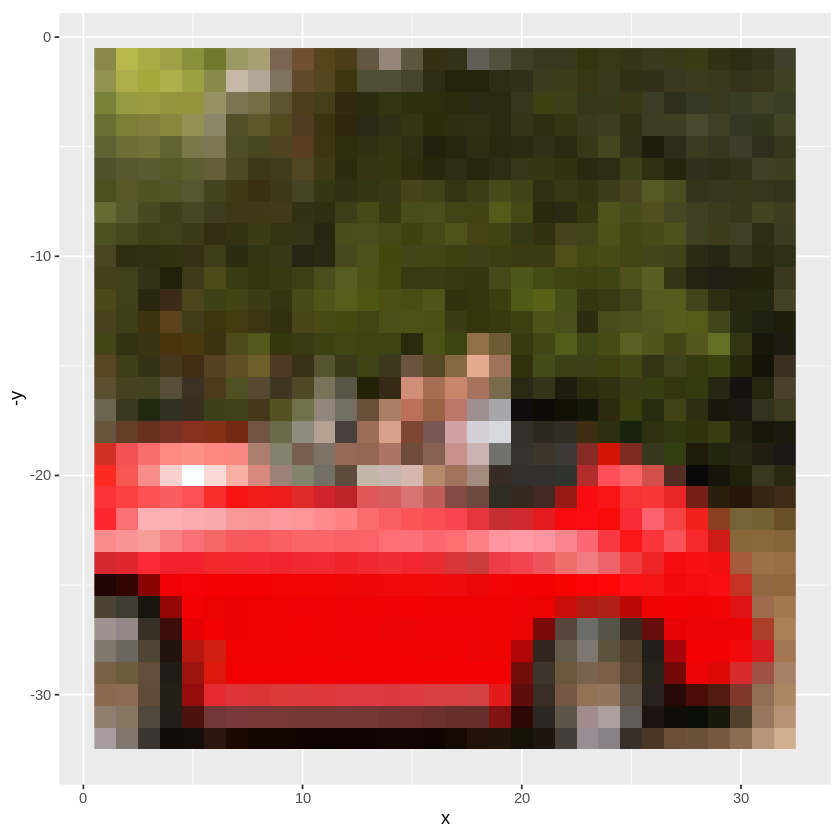

In [ ]:
tibble(
r= X.train$cpu() %>% .[100,1] %>% as_array() %>% as.vector(),
g= X.train$cpu() %>% .[100,2] %>% as_array() %>% as.vector(),
b= X.train$cpu() %>% .[100,3] %>% as_array() %>% as.vector()) %>% 
  bind_cols(
    expand_grid(
      x=seq(32,1),
      y=seq(1,32))) %>% 
  ggplot(aes(x=x,y=-y))+
  geom_raster(aes(fill=rgb(r,g,b)))+
  scale_fill_identity()+
  coord_fixed(ratio = 1)

In [ ]:
batch.size= 64L
epochs= 20L
channel= 64L

ds.train= tensor_dataset(X.train, Y.train)
ds.test= tensor_dataset(X.test, Y.test)

train.loader= dataloader(ds.train, 
                         batch_size = batch.size, 
                         shuffle = T,
                         drop_last = T)
test.loader= dataloader(ds.test, 
                        batch_size = batch.size, 
                        shuffle = F,
                        drop_last = T)

In [ ]:
network= nn_module(
  "cnn_model",
  initialize= function(){
    
    self$input= nn_sequential(
      nn_conv2d(3L,channel,kernel_size = 3L, stride= 1L, padding = 1L),
      nn_batch_norm2d(channel),
      nn_leaky_relu(),
      nn_conv2d(channel,channel,kernel_size = 3L, stride= 1L, padding = 1L), 
      nn_batch_norm2d(channel),  
      nn_leaky_relu(),
      nn_avg_pool2d(2L,2L))
      
    self$cnn= nn_sequential(
      nn_conv2d(channel,channel,kernel_size = 3L, stride= 1L, padding = 1L), 
      nn_batch_norm2d(channel),
      nn_leaky_relu(),
      nn_conv2d(channel,channel,kernel_size = 3L, stride= 1L, padding = 1L), 
      nn_batch_norm2d(channel),  
      nn_leaky_relu(),
      nn_avg_pool2d(2L,2L))

    self$last= nn_sequential(
      nn_conv2d(channel,channel,kernel_size = 3L, stride= 1L, padding = 1L), 
      nn_batch_norm2d(channel),
      nn_leaky_relu(),
      nn_conv2d(channel,channel,kernel_size = 3L, stride= 1L, padding = 1L), 
      nn_batch_norm2d(channel),  
      nn_leaky_relu(),
      nn_avg_pool2d(4L,2L))        
    
    self$mlp= nn_sequential(
      
      nn_linear(channel,100L),
      nn_leaky_relu(),
      nn_batch_norm1d(100L),
      nn_linear(100L,10L))},
    
  forward= function(M){
    M %>% 
      self$input() %>% #[3,32X32] -> [channel,16x16]
      self$cnn() %>%  #[channel,8x8]
      self$cnn() %>%  #[channel,4x4]
      #self$cnn() %>%  #[channel,2x2]
      self$last() %>% #[channel,1x1]
      torch_reshape(list(batch.size,-1L)) %>% 
      self$mlp()}
)

In [ ]:
model= network()$cuda()
loss.fun= nn_cross_entropy_loss()
optimizer= optim_adam(model$parameters)

In [ ]:
b= enumerate(train.loader)
temp= network()$cuda()

In [ ]:
train.losses= vector()
test.losses= vector()

epoch.train.loss= vector()
epoch.test.loss= vector()

for(i in 1:20){
  for(b in enumerate(train.loader)){
    optimizer$zero_grad()
    y_pred= model$forward(b[[1]])
    t.loss= loss.fun(y_pred, b[[2]])
    t.loss$backward()
    optimizer$step()
    train.losses= c(train.losses, t.loss$item())}
  epoch.train.loss= c(epoch.train.loss, t.loss$item())
  
  for(b in enumerate(test.loader)){
    model$eval()
    y_pred= model(b[[1]])
    v.loss= loss.fun(y_pred, b[[2]])
    model$train()
    test.losses= c(test.losses, v.loss$item())}
  epoch.test.loss= c(epoch.test.loss, v.loss$item())
  
  print(paste0("epoch No.: ", i))
  print(paste0("train.loss :", (t.loss$item())))
  print(paste0("test.loss :", (v.loss$item())))
  }

[1] "epoch No.: 1"
[1] "train.loss :1.02764391899109"
[1] "test.loss :1.15308809280396"
[1] "epoch No.: 2"
[1] "train.loss :0.689477682113647"
[1] "test.loss :0.944257140159607"
[1] "epoch No.: 3"
[1] "train.loss :0.654621601104736"
[1] "test.loss :0.7976233959198"
[1] "epoch No.: 4"
[1] "train.loss :0.609312474727631"
[1] "test.loss :0.744799971580505"
[1] "epoch No.: 5"
[1] "train.loss :0.499863505363464"
[1] "test.loss :0.741568744182587"
[1] "epoch No.: 6"
[1] "train.loss :0.494149953126907"
[1] "test.loss :0.520386278629303"
[1] "epoch No.: 7"
[1] "train.loss :0.298547834157944"
[1] "test.loss :0.624603033065796"
[1] "epoch No.: 8"
[1] "train.loss :0.282270908355713"
[1] "test.loss :0.650241315364838"
[1] "epoch No.: 9"
[1] "train.loss :0.47871345281601"
[1] "test.loss :0.544924437999725"
[1] "epoch No.: 10"
[1] "train.loss :0.229193568229675"
[1] "test.loss :0.509182095527649"
[1] "epoch No.: 11"
[1] "train.loss :0.420462965965271"
[1] "test.loss :0.761209428310394"
[1] "epoch No

In [ ]:
tibble(
  No= seq(1, length(train.losses)),
  losses=train.losses) %>% 
  ggplot(aes(x=No, y=losses))+
  geom_point(alpha=0.5,size=0.3,color="red")

tibble(
  No= seq(1, length(test.losses)),
  losses=test.losses) %>% 
  ggplot(aes(x=No, y=losses))+
  geom_point(alpha=0.5,size=0.3,color="blue")

ERROR: ignored

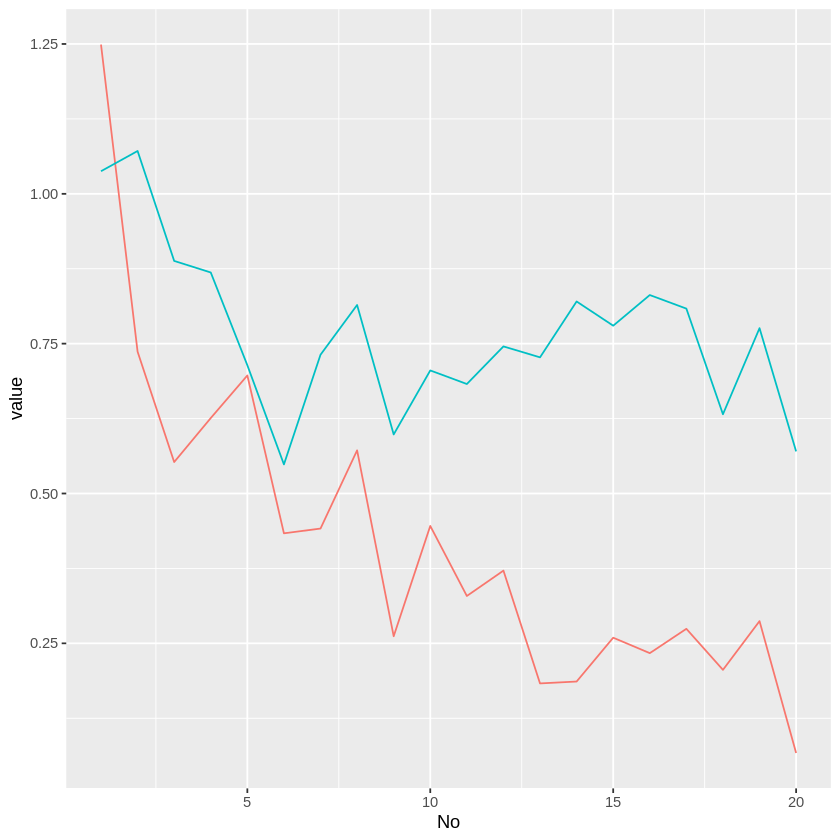

In [ ]:
tibble(
  No= seq(1, length(epoch.train.loss)),
  train= epoch.train.loss,
  valid= epoch.test.loss) %>% 
  pivot_longer(cols=c("train","valid")) %>% 
  ggplot(aes(x=No, y= value))+geom_path(aes(color=name),show.legend = F)

In [ ]:
test.pred= vector()
test.label= vector()

for(b in enumerate(test.loader)){
  pred= b[[1]] %>% model(.)
  test.pred= c(test.pred, torch_max(pred,2)[[2]]$cpu() %>% as_array())
  test.label= c(test.label, b[[2]]$cpu() %>% as_array())}

In [ ]:
df.acc=
  tibble(
    label= test.label %>% as.factor(),
    pred= test.pred %>% as.factor())
df.acc

df.acc %>% accuracy(label, pred)

label,pred
<fct>,<fct>
4,4
9,9
9,9
1,1
7,7
7,7
2,2
7,7
4,4


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.8178085
